# Lab 2: GPs for Non-Gaussian Likelihoods and Big Data

This lab introduces Gaussian process regression for data with non-Gaussian likelihoods, and shows how this can be applied to classification. The concept of sparse methods for Gaussian process regression is introduced for creating a scalable regression model, and this is combined with a large classification problem.

As with Lab 1, the notebook uses `GPy` for handling the regression model and likelihoods.

##  1. Getting started

First we setup our notebook with the libraries we are going to use. As with Lab 1, we use `numpy` for maths functionality, `pyplot` for plotting, and `GPy` for Gaussian processes.

In [1]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

The documentation for `GPy` is available at [gpy.readthedocs.io](http://gpy.readthedocs.io/en/deploy/). We will be using GPy to define our kernels, and regression. Note that `GPy` also contains plotting utilities, but we will not use these in this lab.

We will recycle our GP plotting utility from Lab 1:

In [2]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)), # 95% confidence interval of a Gaussian is
                     m[:,0] + 1.96*np.sqrt(np.diag(C)), # .. contained within mean +/- 1.96*s.d.
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

---
## 2. Non-Gaussian likelihoods

Consider the regression model:

$$
    \mathbf{y} \sim \pi(\mathbf{X}, \varphi),
$$
where $\mathbf{y}$ are some observations given input $\mathbf{X}$ distributed by some likelihood function with parameters $\varphi$.

Previously, we looked at regression models with Gaussian process priors and Gaussian likelihoods:

$$
    \mathbf{y} \sim \mathcal{N}(f(\mathbf{X}), \sigma^2) \qquad \text{which can equivalently be written} \qquad \frac{1}{\sigma}(\mathbf{y} - f(\mathbf{X})) \sim \mathcal{N}(0, 1)
$$

We assume $f \sim \mathcal{GP}(m(\cdot), k(\cdot,\cdot))$ and $\sigma^2$ is the variance of some additive observation noise $\epsilon \sim \mathcal{N}(0, \sigma^2)$. However, often this is not the best way to model a problem, for example in observation models with outliers, or classification problems. For this, we have to make approximations of the likelihood to fit into the GP regression model.

Consider the Olympic men's marathon data, which we will load from a local directory [[full download here]](https://github.com/gpschool/labs/raw/2020/.resources/olympic_marathon_men):

In [3]:
import pickle

with open("olympic_marathon_men", "rb") as fid:
    data = pickle.load(fid)

print("\nData keys:")
print(data.keys())

print("\nCitation:")
print(data['citation'])

print("\nInfo:")
print(data['details'])


Data keys:
dict_keys(['X', 'Y', 'citation', 'details', 'files', 'license', 'size', 'urls'])

Citation:
None

Info:
Olympic mens' marathon gold medal winning times from 1896 to 2012. Time given in pace (minutes per kilometer). Data is originally downloaded and collated from Wikipedia, we are not responsible for errors in the data


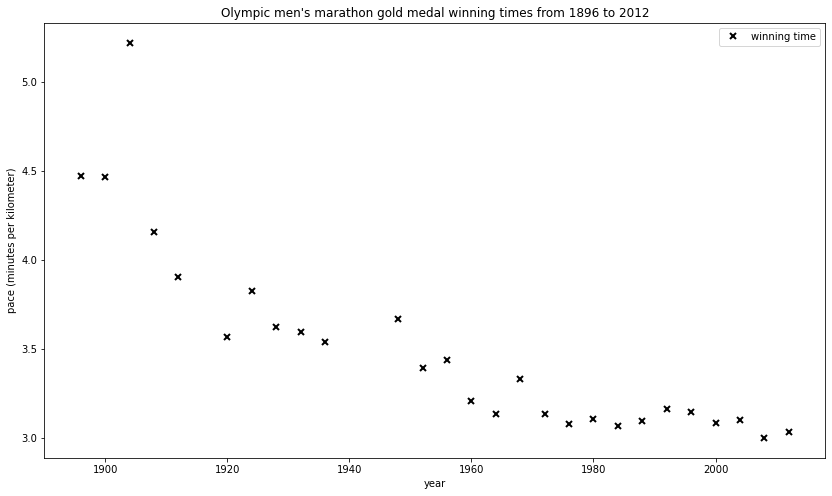

In [4]:
# Training data (X = input, Y = observation)
X, y = data['X'], data['Y']

# Set up our plotting environment
plt.figure(figsize=(14, 8))

# Plot the training data, the results of the gold medal winning time for the Olympic men's marathon
plt.plot(X, y, "kx", mew=2)

# Annotate plot
plt.legend(labels=["winning time"]), plt.xlim((1890, 2018))
plt.xlabel("year"), plt.ylabel("pace (minutes per kilometer)")
plt.title("Olympic men's marathon gold medal winning times from 1896 to 2012");

Notice that there is what looks like an outlier in 1904, which may make it difficult to fit a Gaussian likelhood to the data.

We will attempt to fit a Gaussian process regression model using a Gaussian likelihood. This is equivalent to the regressions we were performing yesterday, which assumed that we could perform exact Gaussian inference due to Gaussian likelihood. The model we used in `GPy` had all of these presets assumed: `models.GPRegression()`, however we will manually set the inference method and likelhood using the `core.GP()` class, which gives us more flexibility for customisation.

The likelihood functions can be found in `GPy.likelihoods`, and we will use `likelihoods.Gaussian()` here, with the variance set to $1.0$. The inference methods for a GP can be found in `GPy.inference.latent_function_inference`, from which we will use `ExactGaussianInference()`, which exploit the properties of tractability we gain from having Gaussian assumptions.

In [5]:
k = GPy.kern.RBF(1, name="rbf")

# The below GP setup is equivalent to
#   m = GPy.models.GPRegression(X, y, k)
# which sets the inference and likelihood to be exact Gaussian inference by default

m = GPy.core.GP( # Note that we are using the core GP model here, which allows us 
    X, y,        # .. to tailor the inference and likelihood later
    kernel = k,  # ... for now we replicate the defaults
    inference_method = GPy.inference.latent_function_inference.ExactGaussianInference(),# Exact Gaussian inference
    likelihood = GPy.likelihoods.Gaussian(variance=1.) # Gaussian likelihood
)
m.optimize()

m

gp.,value,constraints,priors
rbf.variance,25.399514566846776,+ve,
rbf.lengthscale,152.04528250425923,+ve,
Gaussian_noise.variance,0.048506451812473476,+ve,


We predict the race pace defined by the latent function for every year. We will plot the latent function only by not including the likelihood in our prediction. This is equivalent to using `m.predict_noiseless()`, because our likelihood here is latent function augmented with the (zero-mean) Gaussian noise attributed to the measurements. You could try including the likelihood, and see how it incorporates the uncertainty by increasing the confidence intervals about the mean.

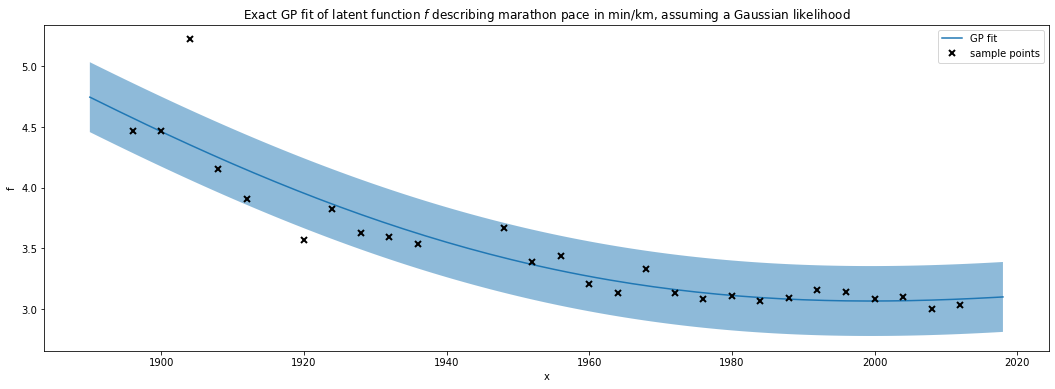

In [6]:
Xnew = np.arange(1890,2019)[:, None] # predict winning pace every year between 1890 and 2018

mean, Cov = m.predict(Xnew, include_likelihood=False)

plt.figure(figsize=(18,6))
# Plot the GP prediction of the latent function with training points
plot_gp(Xnew, mean, Cov, training_points=(X,y))
# Annotate plot
plt.title("Exact GP fit of latent function $f$ describing marathon pace in min/km, assuming a Gaussian likelihood");

While this may seem like an adequate fit, it can be observed that the outlier at 1904 is affecting the mean estimate, as it appears consistently higher than observed measurements for the next three decades. This is due to the Gaussian likelihood assumption means that the regression is heavily affected by the outliers. 

We could alternatively use a heavy tailed [Student's $t$-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) which can reduce the influence of outliers in the inference. Consider the regression model$^\ast$:
$$
    \frac{1}{\sigma^2}(\mathbf{y} - f(\mathbf{X})) \sim \mathcal{T}(\nu)
$$

However, we cannot trivially extend the Gaussian process updates to find the posterior, so some approximation method needs to be used. We will use Laplace's method for approximating the posterior integrals with a Gaussian distribution using second order Taylor expansions. `GPy` contains the utility to include a Laplace approximation in our `GP`.

$^\ast$_note that we write the regression model like this because Student's $t$-distribution is defined with zero mean, and controlled by $\nu$, the degrees of freedom, only. However, we include a scaling parameter, $\sigma^2$ that is equivalent to the variance in our likelihood model (see the Gaussian likelihood example above)_

In [7]:
Xnew = np.arange(1890,2019)[:, None] # predict winning pace every year between 1890 and 2018

# We define a Student's t distribution with default nu=5.0 and sigma^2=2.0
# ... nu describes the degrees of freedom
t_dist  = GPy.likelihoods.StudentT(deg_free=5., sigma2=2.)

# We will use the same kernel, an RBF do desribe the trend and a Bias term to offset the fit
k = GPy.kern.RBF(1, lengthscale=5.) + GPy.kern.Bias(1, variance=4.)

# We fit the model as before, but customise the likelihood (with the t-distribution),
# .. and approximate inference method, here using Laplace

m = GPy.core.GP( # Note that we are using the core GP model here, which allows us 
    X, y,        # .. to tailor the inference and likelihood, instead of the default
    kernel = k,  #  .. GP regression model used previously
    inference_method = GPy.inference.latent_function_inference.Laplace(), # Laplace approximation for inference
    likelihood = t_dist # Our Student's t-distribution with initial parameters defined above
)

# Optimise the kernel and likelihood parameters
m.optimize()

# Preview our model
m

gp.,value,constraints,priors
sum.rbf.variance,0.19110032674577468,+ve,
sum.rbf.lengthscale,22.936313720060994,+ve,
sum.bias.variance,6.192991291185997,+ve,
Student_T.t_scale2,0.005045656781090709,+ve,
Student_T.deg_free,1.9158988932418004,+ve,


Notice that in our list of parameters, we no longer have `Gaussian_noise.variance`, which was the parameter of the Gaussian likelihood, and instead have `Student_T.t_scale2` and `Student_T.deg_free` which correspond respectively to the scale (equivalent to variance), and degrees of freedom that describe our Student's $t$-distribution.

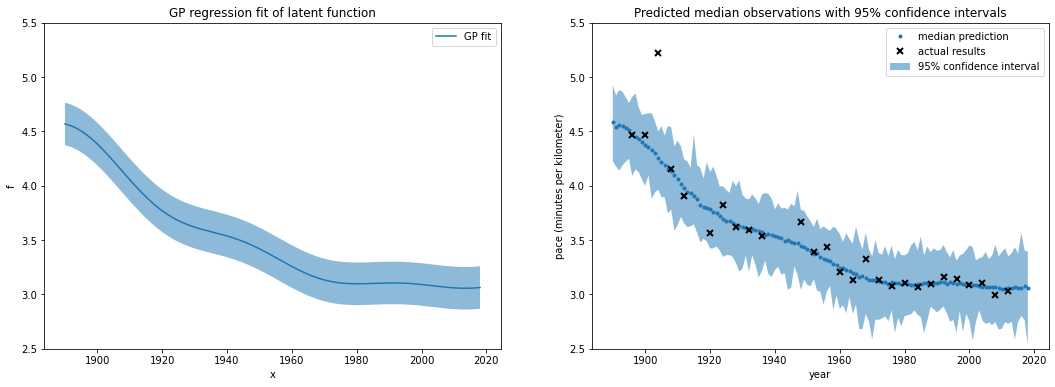

In [8]:
# We plot the latent function without the likelhood
#   This is equivalent to predict_noiseless in the previous lab
mean, Cov = m.predict(Xnew, include_likelihood=False)

# We will also predict the median and 95% confidence intervals of the likelihood
quantiles = m.predict_quantiles(Xnew, quantiles=(2.5, 50., 97.5), likelihood=m.likelihood)

# Prepare figure environment
plt.figure(figsize=(18,6))

plt.subplot(121)
# Plot the GP fit of our latent function f(X)
plot_gp(Xnew, mean, Cov)

# Annotate plot
plt.ylim((2.5, 5.5))
plt.title("GP regression fit of latent function")


plt.subplot(122)
# Plot the median of the predicted likelihood
plt.plot(Xnew, quantiles[1], ".")
# Add a confidence interval between the 2.5 and 97.5 quantiles (95% of predicted data)
plt.fill_between(Xnew[:,0], quantiles[0][:,0], quantiles[2][:,0], alpha=0.5)
# Plot observations
plt.plot(X, y, "kx", mew=2)

# Annotate plot
plt.xlabel("year"), plt.ylabel("pace (minutes per kilometer)"), plt.ylim((2.5, 5.5))
plt.title("Predicted median observations with 95% confidence intervals");
plt.legend(labels=["median prediction", "actual results", "95% confidence interval"]);

When building our confidence intervals in the likelihood, we can no longer rely on the properties of the Gaussian that allow us to build our intervals as a proportion of the standard deviation. Instead, we must obtain the quantiles from the inverse cumulative density function. To obtain the confidence interval, containing 95% of samples from our fit, we must evaluate our inverse CDF at 0.025 and 0.975 (e.g. 2.5% and 97.5% respectively). We also plot the median (i.e. the 50% quantile). `GPy` allows us to obtain the quantiles of the prediction likelihood directly, using `predict_quantiles()`.

We could also also obtain the variance (in the usual way) and plot it as an alternative representation of the uncertainty in our fit.

### Exercise 1

Comment on the fit using the Student's $t$-distribution. Can you make a reasonable prediction (with confidence intervals) for the gold medal time in the 2016 Olympics? How does it compare to the true value ($2016, 3.05$). What about predictions for the next 3 Olympics?

---
## 3. Classification with Gaussian Processes

A common type of problem with non-Gaussian likelihoods are classification problems. Indeed, if the input is some real number and the output is a binary integer or numeric value corresponding to a class, we can often consider these as regression problems with a Bernoulli or categorical likelihood. Using the tricks we have learned above, we should be able to apply Gaussian process priors to a classification problem.

There are different approximation techniques we could use. In the previous example, we used the Laplace approximation, but other alternatives include expectation propagation (EP) and stoachastic variational inference (SVI). Note that `GPy` has a `GPClassification` model that contains sensible defaults, much like the `GPRegression` model used in Lab 1. However, we will construct our GP and manually set the likelihood and approximate inference methods.

### Simulating a binary classification problem

For posterity, we will generate a latent function $f$ that we _know_ is a Gaussian process, by simulating it given an RBF covariance function. We will then use a mapping of the latent function using a [probit](https://en.wikipedia.org/wiki/Probit) transform (which maps a function to $[0,1]$ and is denoted $\Phi$) and sample from the resulting [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution).

In [9]:
# This is important for reproducing the latent function
np.random.seed(4092018)

# The covariance in the latent function is an RBF with l=0.2
k = GPy.kern.RBF(1, variance=1., lengthscale=0.2)

# Create a smooth GP latent function
Xnew   = np.linspace(0., 1., 1000)[:, None]
f_true = np.random.multivariate_normal(np.zeros(1000), k.K(Xnew,Xnew))

## Random sample space over [0, 1]
ix = np.sort(np.random.randint(0, 999, 200))
X, f = Xnew[ix],  f_true[ix]

Note this is an example of a latent function that we have simulated using a _known_ covariance function &ndash; as opposed to our previous GP regression problem, where we only _assumed_ the nature of the covariance function. We will, however, be passing the latent function through a non-Gaussian likelihood over which we can no longer exactly infer the original latent function.

Hence, the regression problem is defined:

$$
    \mathbf{y} = \begin{bmatrix}y_1 \\ \vdots \\ y_N\end{bmatrix}, \quad y_i \sim \mathcal{Bernoulli}\left(p_i\right)\ \text{for }i\in 1,\ldots,N \qquad \text{where } p_i = \Phi\left(f(x_i\right))
$$

The sample inputs are indexed from the set $\mathbf{X} = \{x_1, \ldots, x_N\}$

In [10]:
# Squash the latent function between [0, 1] using the probit link function
probit = GPy.likelihoods.link_functions.Probit()

# Demonstrate the transformation done by the latent function
p_s = probit.transf(f_true) # e.g. p_X in the above equation

# We then draw samples form a Bernoulli distribution with success probability equal
# .. to the transformed latent function
y = GPy.likelihoods.Bernoulli(gp_link=probit).samples(f)[:, None]

We'll plot the latent function (which is a smooth Gaussian process), and samples, showing the squashed probability function of the Bernoulli distribution, and the random samples drawn at the sample locations.

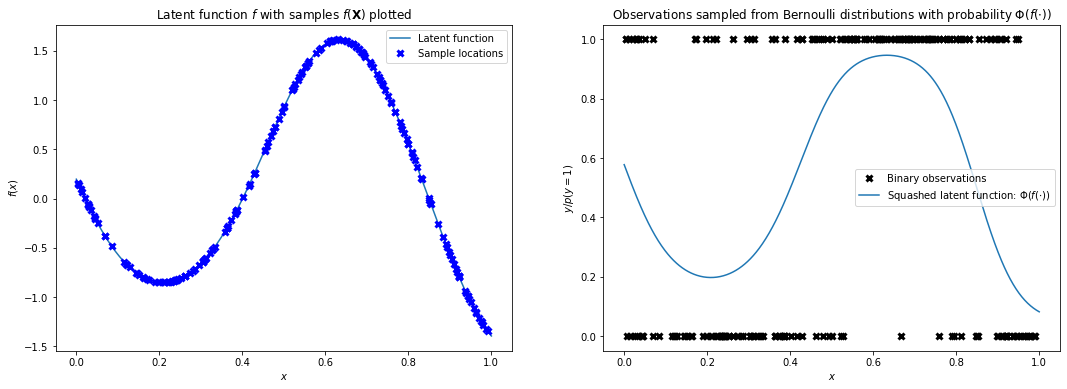

In [11]:
plt.figure(figsize=(18, 6))

# Plot latent function and sample locations
plt.subplot(121)
plt.plot(Xnew, f_true, '-', X, f, "bx", mew=3)

# Annotate plot
plt.xlabel("$x$"), plt.ylabel("$f(x)$")
plt.legend(labels=["Latent function", "Sample locations"])
plt.title("Latent function $f$ with samples $f(\mathbf{X})$ plotted")

# Plot the probit squashed f and samples from the corresponding Bernoulli distribution
plt.subplot(122)
plt.plot(X, y, 'kx', Xnew, p_s, "-", mew=3)

# Annotate plot
plt.xlabel("$x$"), plt.ylabel("$y$/$p(y=1)$")
plt.legend(labels=["Binary observations", "Squashed latent function: $\Phi(f(\cdot))$"], loc='center right')
plt.title("Observations sampled from Bernoulli distributions with probability $\Phi(f(\cdot))$");

### GP Regression with Bernoulli Likelihood

While the regression problem described here may seem _harder_ than modelling the Olympic marathon data with a Student's $t$-distribution, the steps to go through using `GPy` are just as simple.

We will need to define a kernel, a likelihood, and an inference method. Since we know the kernel used to generate the latent function above, we will reuse that (in most cases, this will be unknown). We also know the likelihood used to obtain the measurements (because we defined it to simulate them): a Bernoulli likelihood defined by taking the probit transform of the latent function. We will approximate the posterior of the latent function using these assumptions using the Laplace approximation, as with the $t$-distribution example.

Note, we could also use expectation propagation, `latent_function_inference.EP()`, but in such a simple case the choice of inference approximation method is not going to make much difference.

In [12]:
# We use the kernel used to generate f
k = GPy.kern.RBF(1, variance=1., lengthscale=0.2)

# And a Bernoulli likelihood
B_dist = GPy.likelihoods.Bernoulli(gp_link=probit)

m = GPy.core.GP( # Note that we are using the core GP model here, which allows us 
    X, y,        # .. to tailor the inference and likelihood, instead of the default
    kernel = k,  #  .. GP regression model used previously
    inference_method = GPy.inference.latent_function_inference.Laplace(), # Laplace approximation for inference
    likelihood = B_dist # Our Bernoulli likelihood as defined above
)

m.optimize()

# Preview our model
m

gp.,value,constraints,priors
rbf.variance,1.5571453979111265,+ve,
rbf.lengthscale,0.21042056892234184,+ve,


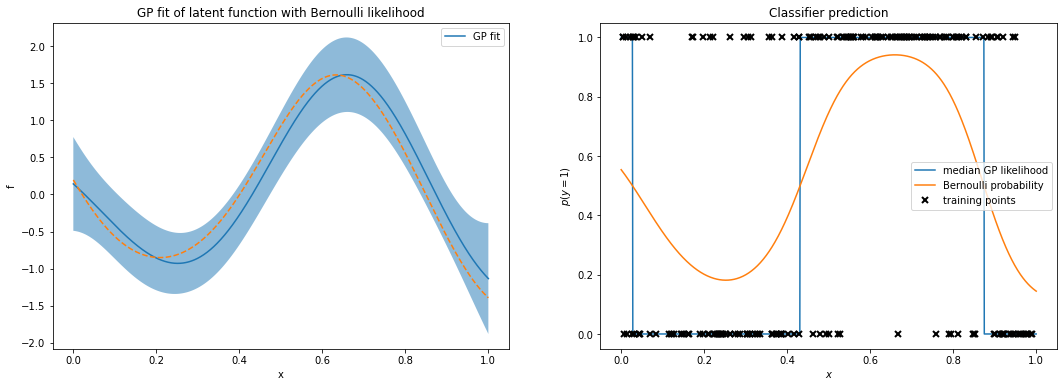

In [13]:
# We plot the latent function without the likelhood
#   This is equivalent to predict_noiseless in the previous lab
mean, Cov = m.predict(Xnew, include_likelihood=False, full_cov=True)

# We will also predict the median and 95% confidence intervals of the likelihood
quantiles = m.predict_quantiles(Xnew, quantiles=np.array([50.]), likelihood=m.likelihood)
prob, _ = m.predict(Xnew, include_likelihood=True) # Probability function for Bernoulli

# Prepare figure environment
plt.figure(figsize=(18,6))

plt.subplot(121)
# Plot the GP fit of our latent function f(X)
plot_gp(Xnew, mean, Cov)

plt.plot(Xnew, f_true, "--")
# Annotate plot
plt.title("GP fit of latent function with Bernoulli likelihood")

plt.subplot(122)
# Plot the median and mean of the predicted likelihood
plt.plot(Xnew, quantiles[0], "-", Xnew, prob, "-")
plt.plot(X, y, "kx", mew=2)

# Annotate plot
plt.xlabel("$x$"), plt.ylabel("$p(y=1)$")
plt.title("Classifier prediction");
plt.legend(labels=["median GP likelihood", "Bernoulli probability", "training points"]);

Here we have plotted the inferred latent function $f$, and on the right, the mean and median of the predicted likelihood. In the Bernoulli distribution, the mean is the probability parameter, $p_i$ of the Bernoulli distribution, and the median is defined as $1$ if $p_i > (1-p_i)$, $0.5$ if $p_i = (1-p_i)$ and $0$ otherwise. This makes it a suitable candidate for a decision boundary, as demonstrated in the above plot.

### Multiple Input Classification

We can apply the above example to a 2-D classification example. Taking the multi-input example from Lab 1, we will define our latent function, $f(x_i, x_j)$, as the product of sinusoids in the respective input dimensions $x_i$ and $x_j$ and create a classifier that evaluates an input based on whether it's greater than zero or not:

$$
    y(x_i,x_j) = \begin{cases}1 & \text{if } f(x_i,x_j) + \varepsilon > 0 \\ 0 & \text{otherwise} \end{cases},
$$

where $\varepsilon \sim \mathcal{N}(0, 1e-4)$ describes some random observation noise in our classifier. Note that this is not exactly a Bernoulli distribution, as was the case in the previous example, but we will attempt to fit it with one with our GP regression model.

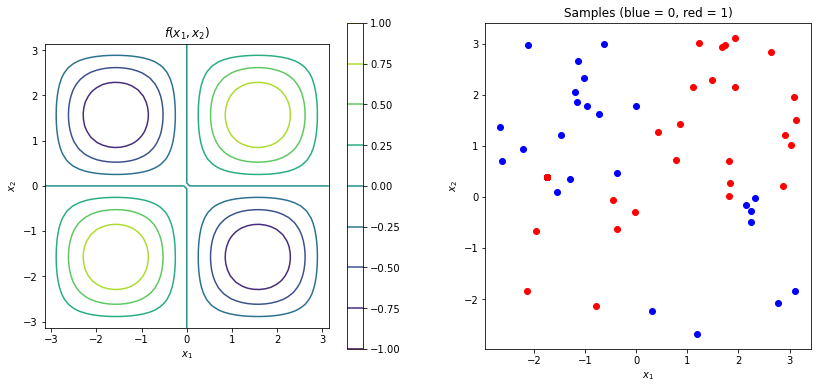

In [14]:
# Lambda function, f, the unknown function we are trying to predict
f = lambda xi,xj: np.sin(xi) * np.sin(xj)

# Our test grid
[Xi, Xj] = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))

# Number of samples [YOU CAN PLAY AROUND WITH THE NUMBER OF RANDOM SAMPLES TO SEE HOW THE FIT IS AFFECTED]
num_measurements = 50

# Random sample locations (2-D)
X2 = np.random.uniform(-np.pi, np.pi, (num_measurements, 2))

# Setup plot enviornment
plt.figure(figsize=(14, 6))

plt.subplot(121)
# Show true function
plt.contour(Xi, Xj, f(Xi,Xj))
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.colorbar()
plt.title("$f(x_1,x_2)$"), plt.axis("square")

# Our observations, y = 1 if [f(x1,x2) + epsilon > 0]otherwise 0
y = np.array(f(X2[:,0], X2[:,1]) + 0.01*np.random.randn(num_measurements) > 0, dtype=np.int)[:, None]

plt.subplot(122)
# Show sample locations
plt.plot(X2[np.where(y == 0),0], X2[np.where(y == 0),1],'bo') # Plot 0 class
plt.plot(X2[np.where(y == 1),0], X2[np.where(y == 1),1],'ro') # Plot 1 class
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$"), plt.axis("square")
plt.title("Samples (blue = 0, red = 1)");

### Exercise 2

(a) Fit a Gaussian process to the observation data for the 2-D classification example, using a Bernoulli likelihood. Try and recover the probability surface for the Bernoulli distribution over input space `Xnew2`.

_Remember from Lab 1 that we need to reshape our output into a grid the same shape as our inputs: e.g._ `mean2.reshape(Xi.shape)`

In [15]:
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T # Change our input grid to list of coordinates

# Put your answer here

(b) Find a decision boundary and plot it over the input space `Xnew2` along with the samples. What do you think of the decision boundary? Does it capture the rules of the classifier?

(c) As mentioned before, the mean of a Bernoulli distribution is $p$. The variance is defined by $p(1-p)$. Plot the variance of your GP likelihood fit and comment on how it might reflect the uncertainty in the predicted classifier.

---
### Credit

This notebook was written by Wil Ward. It adapted from notebooks by [Rich Wilkinson](https://rich-d-wilkinson.github.io/) and [Neil Lawrence](http://inverseprobability.com/), and [James Hensman](http://jameshensman.github.io/). Additional writing and examples were provided by Fariba Yousefi and Juan Jose Giraldo Gutierrez.